In [53]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import pandas as pd
from astropy.table import Table, vstack
import hdbscan
from pathlib import Path
import seaborn as sns
import glob
import json
%matplotlib inline
sns.set_color_codes()

In [54]:
ROOT_PATH = Path("..") 

In [55]:
df = pd.read_csv("Gaia-Final-list-emitters-allparam-unique.csv")

In [56]:
print("Shape of the DataFrame: ", df.shape)
# calculate summary statistics for the data
df.describe().transpose() 

Shape of the DataFrame:  (4907, 93)


,count,mean,std,min,25%,50%,75%,max
RA,4907.0,196.330566,98.125513,0.627955,152.347816,165.417285,300.858255,359.980041
DEC,4907.0,-20.387599,17.389783,-60.062208,-35.525572,-21.955697,-0.889995,6.102812
FWHM,4907.0,5.614658,18.229490,1.569742,2.392572,3.075559,4.232818,1021.657960
ISOarea,4907.0,303.801712,5629.453514,4.000000,20.000000,33.000000,65.000000,378866.000000
KRON_RADIUS,4907.0,4.123634,1.060116,0.000000,3.574161,3.994644,4.642466,8.696955
...,...,...,...,...,...,...,...,...
phot_bp_rp_excess_factor_corrected,4849.0,2.237578,8.024819,-0.618000,-0.019000,0.017000,0.282000,116.723000
ra_epoch2000_error,4907.0,7.513352,8.203953,0.239500,2.516000,4.852700,9.014000,90.786200
dec_epoch2000_error,4907.0,6.758078,7.810882,0.267200,2.337000,4.265800,7.786900,90.644000
ra_dec_epoch2000_corr,4907.0,0.101591,0.331291,-0.989700,-0.128150,0.132400,0.336100,0.994600


Creating color-magnitud diagram

In [57]:
m = np.isfinite(df['phot_g_mean_mag']) & np.isfinite(df['bp_rp'])
df = df[m]
len(df)

4849

In [58]:
 # G-mag
Gmag = np.array(df["phot_g_mean_mag"]) 
  
# Color
#cbp_rpmag = df["phot_bp_mean_mag"] - df["phot_rp_mean_mag"]
bp_rpmag = np.array(df["bp_rp"])

/home/luis/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/luis/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


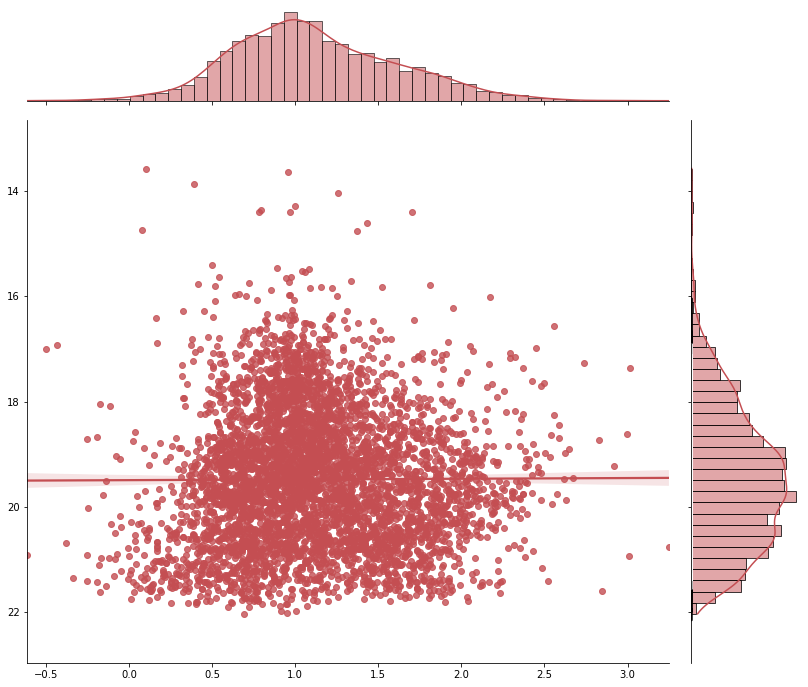

In [59]:
ax = sns.jointplot(bp_rpmag, Gmag, kind="reg", color="r")
#ax.ax_joint.set(xlim=[-0.5, 3.5], ylim=[15, 22.2],
               #xlabel=r"$G_{BP} - G_{RP}$",
    #ylabel=r"$G$")
pal = sns.cubehelix_palette(start=1, rot=0, dark=-10, light=50, reverse=True, as_cmap=True)
sns.kdeplot(
    bp_rpmag, Gmag,
    cmap=pal,
)

#ax.ax_joint.set_aspect("equal")
ax.fig.set_size_inches(12, 10)
plt.gca().invert_yaxis()

# Hierarchical Clustering

In [60]:
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

In [61]:
X = np.array(list(zip(bp_rpmag, Gmag)))
X.shape
# Standarized the data
X = StandardScaler().fit_transform(X)

In [62]:
X.shape

(4849, 2)

In [68]:
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
model.fit_predict(X)

array([2, 1, 1, ..., 2, 0, 0])

In [69]:
label = model.labels_

/home/luis/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


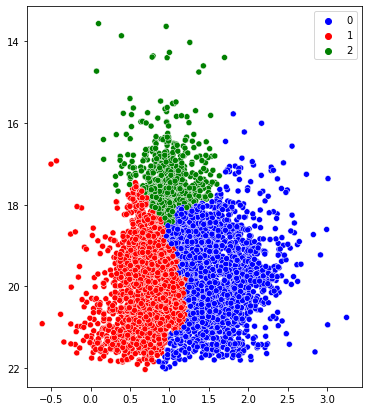

In [71]:
plt.figure(figsize=(6, 7))
#plt.axis([-6.8, 2.5, -3., 5.])
sns.scatterplot(bp_rpmag, Gmag, 
                hue=label,
                palette=["blue","red", "green"])
plt.gca().invert_yaxis()

In [74]:
df["Label"] = label
mask_1 = df["Label"] == 1
df_1 = df[mask_1]

In [75]:
df_1

,Field,ID,RA,DEC,FWHM,ISOarea,KRON_RADIUS,MU_MAX,nDet_PStotal,PhotoFlagDet,...,phot_rp_mean_mag_error,phot_g_mean_mag_corrected,phot_g_mean_mag_error_corrected,phot_g_mean_flux_corrected,phot_bp_rp_excess_factor_corrected,ra_epoch2000_error,dec_epoch2000_error,ra_dec_epoch2000_corr,angDist,Label
1,HYDRA-0050,iDR3.HYDRA-0050.016160,151.639026,-29.935504,7.208158,1800,3.511517,13.253312,12.0,3,...,0.008331,18.022939,0.008303,1163.5100,8.983,7.4670,6.7673,-0.0228,0.201862,1
2,SPLUS-n15s22,iDR3.SPLUS-n15s22.026619,180.477264,-18.884388,4.706558,242,3.587953,12.723707,12.0,3,...,0.022149,19.053156,0.023571,450.4890,19.368,5.3432,4.8091,-0.6232,0.630048,1
4,HYDRA-0017,iDR3.HYDRA-0017.040891,159.626433,-23.548533,7.848790,624,3.961594,14.543225,12.0,2,...,0.020952,20.627770,0.066133,105.6430,34.983,15.4058,14.3224,0.3218,0.136727,1
6,HYDRA-0020,iDR3.HYDRA-0020.053613,163.840107,-23.424237,5.089529,1011,3.912242,13.724796,12.0,3,...,0.010660,20.804356,0.074654,89.7852,52.883,14.0940,12.4987,0.3724,0.188590,1
7,HYDRA-0026,iDR3.HYDRA-0026.043548,159.524335,-25.094460,9.730544,872,4.438001,13.805141,12.0,3,...,0.010019,20.978352,0.036908,76.4903,58.562,16.9795,17.5999,-0.2337,0.644636,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4797,SPLUS-s23s10,iDR3.SPLUS-s23s10.008671,14.511606,-30.073106,4.196454,9,4.048069,17.900736,11.0,0,...,0.265267,21.038628,0.021275,72.3596,0.154,6.1713,1.9268,-0.0190,0.195417,1
4798,SPLUS-s23s33,iDR3.SPLUS-s23s33.028767,333.168192,-29.520124,2.670221,7,4.248485,16.898054,12.0,0,...,0.227688,20.821945,0.014367,88.3422,0.182,2.2809,2.5451,0.8856,0.143426,1
4801,SPLUS-n15s21,iDR3.SPLUS-n15s21.025848,178.479575,-18.998194,3.149463,10,5.238959,17.606527,11.0,0,...,0.250351,20.744146,0.015222,94.9047,0.058,2.3242,1.1809,0.2579,0.160887,1
4864,HYDRA-0113,iDR3.HYDRA-0113.105918,152.339967,-38.393456,6.733094,90,3.557515,13.813911,10.0,0,...,0.018281,18.327194,0.004053,879.1640,7.942,4.2495,4.4884,0.8530,0.659943,1
